###Run a RFR on a set of the data and a synthetic set created from each spaxel

This is the third (or maybe fourth) notebook in the series for unsupervised learning.

We'd like to understand what the correlations in the dataset look like so we'll create fake data from
the marginal distribution of each spaxel :)

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import marvin
from marvin import config, marvindb
# Again, if this doesn't work, go read these instructions on setting it up - https://github.com/sdss/marvin
from marvin.tools.maps import Maps
import pyfits
import os
from marvin.tools.query import Query
from sh import gunzip
from marvin.utils.general import downloadList
import random
import re
from astropy.io import fits


%matplotlib inline

config.access = 'collab'#'collab' if collab
# Option to choose the data release you would like to use:
config.setRelease('MPL-8')#MPL-8 if public
print('Access is',config.access)

# Okay so now that you have downloaded everything it is time to search through your directory for maps
# and assembly a list of existing data in order to run an analysis



# You can also use os to get you the names of all directories in a folder
#print(os.listdir())
# This will yield a tuple for each subdirectory. Ths first entry in the 3-tuple is a directory name, so:

plates = [x[0] for x in os.walk('/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/')]




existing_plateifus=[]

for j in range(len(plates)):
    if re.split('/',plates[j])[-2]=='VOR10-MILESHC-MILESHC':# or re.split('/',plates[j])[-1] != '12701':
        continue
    else:
        existing_plateifus.append(str(re.split('/',plates[j])[-2])+'-'+str(re.split('/',plates[j])[-1]))
#print(existing_plateifus)
print('this is how many galaxies you are working with (that exist on your computer)', len(existing_plateifus))
# Now you need to construct plateifu names of what exists

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/marvin_brain/python/brain/__init__.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open(os.path.join(os.path.dirname(__file__), 'data/brain.yml')))
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/__init__.py:128: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/tree/python/tree/__init__.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(ff)


INFO: No release version set. Setting default to MPL-8


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/marvin/extern/sdss_access/python/sdss_access/__init__.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(ff)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/

Access is collab
this is how many galaxies you are working with (that exist on your computer) 1046


In [3]:
# I'm running into a weird limit error code:
# OSError: [Errno 24] Too many open files
import resource
print(resource.getrlimit(resource.RLIMIT_NOFILE))
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

(4096, 9223372036854775807)


This next section goes about building the map_array_ml, which contains all of the galaxies.

In [4]:

# Here you will assemble a list of the maps from the plateifu list - you could also do this for different
# DAP quantities like other emission lines
# You could also make an array that has multiple maps for each galaxy, but I'll start with one, just
# the stellar velocity maps.
# This section of code stacks them into an array, map_array_ml

# Note that this part takes a little while to run

# First, determine the shape:
shape = np.shape(Maps(existing_plateifus[0])['stellar_vel'].value)[1]
shape = 76 # This is I think the maximum size of these cubes

map_array=[]
map_array_ml = np.zeros((len(existing_plateifus),shape**2))#np.zeros((len(plateifu_list),74**2))
ifu_name=[]
counter=0
for j in range(len(existing_plateifus)):
    '''print('existing_plateifus', existing_plateifus[j])
    print(str(re.split('-',existing_plateifus[j])[-2])+'-'+str(re.split('-',existing_plateifus[j])[-1]))
    print(str(re.split('-',existing_plateifus[j])[-2]))
    if j > 2:
        STOP'''
    try:
        mapit = Maps(filename='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(re.split('-',existing_plateifus[j])[-2])+'/'+str(re.split('-',existing_plateifus[j])[-1])+'/manga-'+existing_plateifus[j]+'-MAPS-VOR10-MILESHC-MILESHC.fits')['stellar_vel'].value
    except:
        mapit = Maps(filename='/Users/beckynevin/sas/mangawork/manga/spectro/analysis/v2_5_3/2.3.0/VOR10-MILESHC-MILESHC/'+str(re.split('-',existing_plateifus[j])[-2])+'/'+str(re.split('-',existing_plateifus[j])[-1])+'/manga-'+existing_plateifus[j]+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz')['stellar_vel'].value
     
    #mapit = Maps(existing_plateifus[j], mode='local', bintype='VOR10', data_origin='db')['stellar_vel'].value
    
    #if plateifu_list[j][-5:-1]=='1270':
        
    try:
        map_array.append(mapit)
        shape_here = int(np.sqrt(np.shape(mapit)[0]))
        
        
        map_array_ml[j,:] = np.reshape(mapit,(shape**2))
        
        '''plt.clf()
        plt.imshow(Maps(existing_plateifus[j])['stellar_vel'].value)
        plt.colorbar()
        plt.show()
        print(np.shape(Maps(existing_plateifus[j])['stellar_vel'].value), shape)'''
    except: # If this doesn't work you have to pad it first
        # First, determine the difference in shape to make up
        try:
            shape_here = np.shape(mapit)[0]
        
            pad_total = shape - shape_here

            padded_array = np.pad(mapit, (int(pad_total/2),int(pad_total/2)), 'edge')
        except:
            print('cannot pad')
            plt.clf()
            plt.imshow(mapit)
            plt.colorbar()
            plt.show()
            print(np.shape(mapit), shape)
            STOP
            continue
        
        '''plt.clf()
        plt.imshow(padded_array)
        plt.colorbar()
        plt.show()'''
        map_array_ml[j,:] = np.reshape(padded_array,(shape**2))
        print(j)
    ifu_name.append(existing_plateifus[j])
    counter+=1
    # You can set a limit using the below commented out code if you do not need a big training set:
    #if counter > 200:
    #    break
# I have found that it hangs after ~220 galaxies (Brainerror - too many requests for url),
# so you would have to have a dedicated server to store the maps and not do it remotely 
# OR you would have to use a different method to grab the maps.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

What if I instead want to play with existing kin maps (that I have de-rotated)?


In [5]:
plates = [x[2] for x in os.walk('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/')][0]
print('total number of kin maps', len(plates))
# Here you will assemble a list of the maps from the plateifu list - you could also do this for different
# DAP quantities like other emission lines
# You could also make an array that has multiple maps for each galaxy, but I'll start with one, just
# the stellar velocity maps.
# This section of code stacks them into an array, map_array_ml

# Note that this part takes a little while to run

# First, determine the shape:
shape = 76 # This is I think the maximum size of these cubes

map_array=[]
map_array_ml = np.zeros((len(plates),shape**2))#np.zeros((len(plateifu_list),74**2))
ifu_name=[]
counter=0
for j in range(len(plates)):
     
    mapkin = fits.open('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/'+plates[j])
    mapit = np.array(np.ma.masked_where(mapkin[2].data==0.0, mapkin[2].data))
    '''plt.imshow(np.ma.masked_where(mapit[2].data==0.0, mapit[2].data), 
               vmin=-100, vmax=100, cmap='RdBu_r')
    plt.colorbar()
    plt.show()
    STOP'''
    try:
        map_array_ml[j,:] = np.reshape(mapit,(shape**2))

    
    except: # If this doesn't work you have to pad it first
        # First, determine the difference in shape to make up
        try:
            shape_here = np.shape(mapit)[0]
        
            pad_total = shape - shape_here

            padded_array = np.pad(mapit, (int(pad_total/2),int(pad_total/2)), 'edge')
        except:
            print('cannot pad')
            plt.clf()
            plt.imshow(mapit)
            plt.colorbar()
            plt.show()
            print(np.shape(mapit), shape)
            STOP
            continue
        
        '''plt.clf()
        plt.imshow(padded_array)
        plt.colorbar()
        plt.show()'''
        map_array_ml[j,:] = np.reshape(padded_array,(shape**2))
        print(j)
    ifu_name.append(existing_plateifus[j])
    counter+=1
    # You can set a limit using the below commented out code if you do not need a big training set:
    #if counter > 200:
    #    break
# I have found that it hangs after ~220 galaxies (Brainerror - too many requests for url),
# so you would have to have a dedicated server to store the maps and not do it remotely 
# OR you would have to use a different method to grab the maps.


total number of kin maps 1043


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8155-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8997-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8328-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8600-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8938-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8079-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9001-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8146-6103.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8611-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9883-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9864-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8986-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10508-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8252-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9185-9101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8944-6103.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8601-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9505-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8993-3701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8453-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7960-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8595-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9184-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10214-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8249-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8949-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8243-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9883-1901.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8725-1901.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9510-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7968-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9038-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9044-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8953-3702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9878-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8450-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8152-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8728-3704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8990-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8977-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10504-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8619-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8725-3704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9088-3701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9863-6102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8459-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8482-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9033-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9486-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8553-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8995-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8317-6103.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8549-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9865-9101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10492-6103.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8613-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8131-1902.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10506-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8135-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8657-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8950-3704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9034-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7958-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8591-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9039-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8458-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8147-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10504-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

['9036-3701', '9036-12703', '9036-12705', '7990-12705', '7990-12702', '7990-12701', '8322-6102', '8322-1901', '7964-12703', '7964-12704', '7964-12705', '7964-12702', '7964-12701', '7964-3703', '9499-12703', '9499-12704', '9499-6103', '8325-12703', '8325-12705', '8325-12702', '9031-12703', '9031-12704', '9031-12705', '9031-12702', '9031-12701', '9497-12704', '9497-12701', '8313-12703', '8313-6102', '9038-12704', '9038-12702', '9000-12703', '9000-12704', '9000-12705', '9000-3702', '9000-12701', '9000-3704', '9490-3701', '8985-6103', '8985-12701', '10497-6104', '9868-1901', '8724-12703', '8982-6102', '8723-6104', '8723-3702', '8723-6101', '8949-12703', '8949-12705', '8949-6101', '9892-6104', '9892-6101', '8940-12703', '8940-12704', '8940-12705', '8940-12702', '8940-12701', '9091-3703', '8143-1902', '8143-3704', '8715-12703', '8715-6103', '8715-12701', '8947-12703', '8947-12704', '8947-12705', '8947-12702', '8947-6104', '8712-6103', '8712-6102', '8144-12703', '8144-12704', '8144-12702', '8

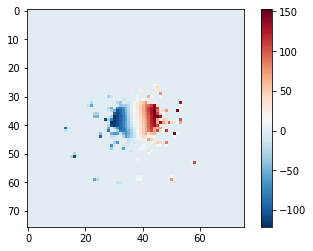

In [6]:
# This is how many galaxies you have in your map_array_ml cube
print(ifu_name)
print(len(ifu_name))


# To prepare the map cube (map_array_ml) for ML algorithms,
# it is necessary to first cut off all the empty rows.

# Removing all rows that were not filled (above)
data = map_array_ml[~np.all(map_array_ml == 0, axis=1)]
#print(np.shape(data))
plt.imshow(np.reshape(data[60], (76,76)), cmap='RdBu_r')
plt.colorbar()
plt.show()
data_length = np.shape(data)[0]
map_array_ml = data

size = int(np.sqrt(np.shape(map_array_ml[0])[0]))
map_array_ml = data
#map_array_ml = np.ma.masked_where(data==0., data)

### Now look at the distribution of each spaxel :)


In [71]:
# Maybe unflatten it first?
full_data = np.reshape(map_array_ml,(np.shape(map_array_ml)[0],shape,shape))
n_galaxies = np.shape(map_array_ml)[0]
print(np.shape(full_data))

MB_matrix = np.zeros(( np.shape(map_array_ml)[0],full_data[0,:,:].size))
for i in range(np.shape(map_array_ml)[0]):
    MB_array = full_data[i,:,:].flatten()
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()
    MB_matrix[i,:] = MB_arrayStd
 
# Re-flatten
print(np.shape(MB_matrix))

MB_matrix_flat = np.reshape(MB_matrix, (np.shape(MB_matrix)[0], shape,shape))

(1043, 76, 76)
(1043, 5776)


In [47]:
###But this matrix is huge

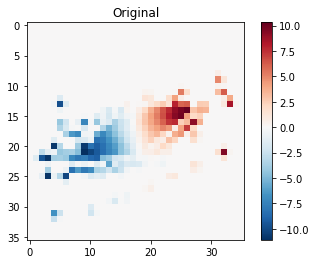

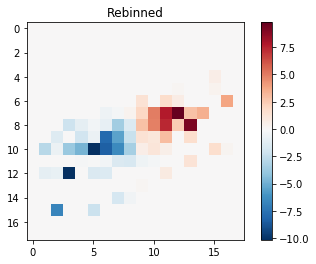

324


In [105]:
import scipy.ndimage as ndi
sidecut = 20

full_data_cut = MB_matrix_flat[:,sidecut:76-sidecut,sidecut:76-sidecut]

idx = 200
rebin = scipy.ndimage.zoom(full_data_cut[idx,:,:], 0.5, order=0)


plt.clf()
plt.imshow(full_data_cut[idx,:,:], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.colorbar()
plt.title('Original')
plt.show()
plt.clf()
plt.imshow(rebin, cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.title('Rebinned')
plt.colorbar()
plt.show()

print(np.shape(rebin)[0]**2)

# Now resize EVERYTHING
resized_full_data = np.zeros((np.shape(full_data_cut)[0], np.shape(rebin)[0], np.shape(rebin)[1]))
for j in range(np.shape(full_data_cut)[0]):
    rebinned = scipy.ndimage.zoom(full_data_cut[j,:,:], 0.5, order=0)
    resized_full_data[j,:,:] = rebinned


In [106]:
MB_matrix_rescaled = np.reshape(resized_full_data, 
                                (np.shape(resized_full_data)[0], np.shape(resized_full_data)[1]**2))

<Figure size 432x288 with 0 Axes>

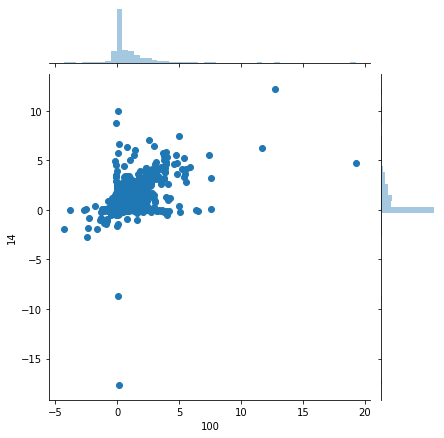

In [107]:


import seaborn as sns
plt.clf()

x = MB_matrix_rescaled[:,100]
y = MB_matrix_rescaled[:,101]
g = (sns.jointplot(x, y)
        .set_axis_labels("100", "14"));#, kind="hex"

# IDK these all look really correlated



In [19]:
### Try producing a marginal dist

1008


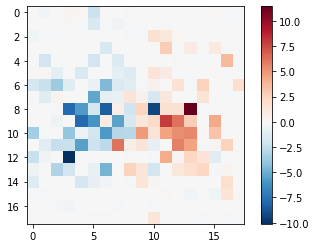

In [108]:
from random import randint
value = randint(0, np.shape(MB_matrix)[0])
print(value)

frankenstein_array = np.zeros(np.shape(MB_matrix_rescaled))

for i in range(np.shape(MB_matrix_rescaled)[0]):
    frankenstein_gal = []
    for j in range(np.shape(MB_matrix_rescaled)[1]):
        ran_int = randint(0,np.shape(MB_matrix_rescaled)[0] - 1)
        frankenstein_gal.append(MB_matrix_rescaled[ran_int,j])
    frankenstein_array[i,:] = frankenstein_gal
    
plt.clf()
plt.imshow(np.reshape(frankenstein_gal, (np.shape(rebin)[0],np.shape(rebin)[0])), cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.colorbar()
plt.show()

In [24]:
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 
from matplotlib import pyplot as plt


class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    #elev_min=-150
    #elev_max=3000
    


In [39]:
###Frankenstein_gal is the same length and size as our actual data, let's run an RFR to see what we're dealing with

(1043, 324) (1043, 324)
finding test and train indices...
training fold 0


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


predicting...
0.0 0.21428571428571427
0.0 0.25022886410191947
0.0 0.33616860585227815
0.0 0.15354149350150542
0.0 0.2266830753056544
0.0 0.1094855305466238
0.0 0.15354149350150542
0.0 0.22355807530565439
0.0 0.2254172525208443
0.0 0.15354149350150542


<Figure size 432x288 with 0 Axes>

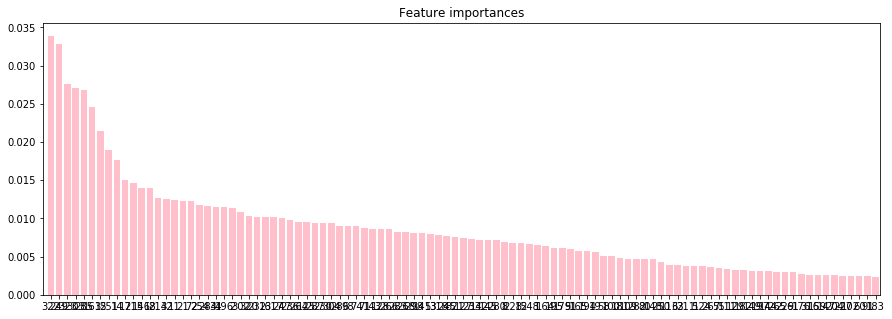

Importance in Order ~~~~
mostimp [322 249 323 303 285 161  35 251  14  17 215 146  18 214  32  11  21  72
 254 284  34 196   2 302 320 232  16 317 247 236 264 125 287 230 304 286
  98  74  71 143 128 266 283 268 298 141  53 318 245 321 127 233 142 145
 280   8 228  15 248   1 164 195 179  51 165 194  19  58 100 181 109 282
  80 148 250 113  63 211   5 124 267  55 111 129 182 149 197 144 265 229
  61 176 316 159 147 204 227 102  60  91] [0.03389047 0.03279142 0.02759459 0.02706721 0.02678153 0.02458207
 0.02140113 0.01893807 0.01769277 0.01507009 0.01466697 0.0140019
 0.0139435  0.01267835 0.01258865 0.01246234 0.01223432 0.01222016
 0.01171574 0.01168087 0.01144959 0.01143    0.01133074 0.01090445
 0.01029401 0.01023149 0.01021463 0.01018112 0.01002786 0.00981693
 0.00956706 0.00953443 0.0094556  0.00940263 0.00938841 0.00899085
 0.00898065 0.00894639 0.00877006 0.00867626 0.00864947 0.00858536
 0.00822862 0.00820693 0.0081234  0.0080631  0.00797212 0.00784848
 0.00775311 0.00751159 0.

In [132]:
most_imp = run_RFR(np.ma.masked_where(MB_matrix_rescaled==0, MB_matrix_rescaled), 
                   np.ma.masked_where(frankenstein_array==0, frankenstein_array), 100)

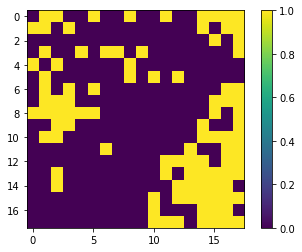

In [133]:
#Wait so you need to figure out which spaxel this is
#322, where is this?

full_length = np.shape(MB_matrix_rescaled)[1]
empty = np.zeros(np.shape(MB_matrix_rescaled)[1])
empty[most_imp] = 1
side = int(np.sqrt(len(empty)))
twod = np.reshape(empty, (side,side))
plt.imshow(twod)
plt.colorbar()
plt.show()


In [124]:
import numpy as np
import pandas as pd

#!/usr/bin/env python


#Usage: a simple implementation of an RFR on toy data



import matplotlib
#matplotlib.use('Agg')
import numpy as np
#from astropy.stats import biweight_scale
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from astropy.io import fits


########################### ADJUSTABLE PARAMETERS ###########################
Nfolds = 10
Ndat = 5000

#############################################################################
 



    
def testAndTrainIndices(test_fold, Nfolds, folds):
    
    print('finding test and train indices...')

    train_folds = np.delete(np.arange(Nfolds), test_fold)

    test_ind   = [i for i in range(len(folds)) if folds[i]==test_fold]
    train_ind  = [i for i in range(len(folds)) if folds[i] in train_folds]

    return test_ind, train_ind



def run_RFR(features_real,features_fake, nimp):
    print(np.shape(features_real), np.shape(features_fake))
    # np.vstack((a,b))
    features = np.vstack((features_real,features_fake))
    
    Nfeatures = len(features[0])
    
    #dat['features']#.reshape(-1,1)
    label_real = np.zeros(np.shape(features_real)[0])
    
    label_fake = np.ones(np.shape(features_fake)[0])
    
    
    
    labels = np.hstack((label_real,label_fake))
    
    
    folds = np.arange(len(labels))%Nfolds
    
    
    #Test on fold 0, train on the remaining folds:
    test_ind, train_ind = testAndTrainIndices(test_fold = 0, Nfolds = Nfolds, folds=folds)
    
    #divide features and labels into test and train sets:
    test_features = features[test_ind]
    test_labels   = labels[test_ind]
   
    train_features  = features[train_ind]
    train_labels    = labels[train_ind]

    print('training fold 0')
    #make a random forest model:
    model = RandomForestRegressor(max_depth=10, random_state=42)
    model.fit(train_features, train_labels)

    print('predicting...')
    # Predict on new data
    preds = model.predict(test_features)
    #print out the first few mass predictions to see if they make sense:
    for h in range(10):
        print(test_labels[h], preds[h])


    
    x = np.linspace(min([np.min(test_labels), np.min(preds)]), \
                        max([np.max(test_labels), np.max(preds)]), 100)
    '''plt.plot(x, x, c='k', ls='--')
    plt.scatter(test_labels, preds, s=3, alpha=0.3)
    plt.xlabel('truth')
    plt.ylabel('prediction')
    plt.show()'''
    #plt.savefig('rfrscatter.pdf')
    plt.clf()

    # rank feature importance:
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
    plt.title("Feature importances")
    plt.bar(range(Nfeatures), importances[indices],  align="center", color='pink')#yerr=std[indices],
    plt.xticks(range(Nfeatures), indices)
    plt.xlim([-1, nimp+0.5])
    plt.show()
    
    #plt.savefig('feature_importance_'+str(run)+'_rando.pdf')
    
    
    
    print('Importance in Order ~~~~')
    print('mostimp', indices[0:nimp], importances[indices][0:nimp], std[indices][0:nimp])
    
  
    return indices[0:nimp]
